<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B06%5D%20-%20Deep%20Learning/MLP_Basic_Step_by_Step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP Progresivo: De Básico a Optimizado

## Máster de FP en Business Analytics e IA
### Profesor: Álvaro López Barbera

En este notebook construiremos 5 modelos progresivamente mejores:

1. Modelo Básico (sin regularización)
2. Modelo con Dropout
3. Modelo con Batch Normalization
4. Modelo con L2 Regularization
5. Modelo Optimizado Final

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(42)
tf.random.set_seed(42)
import warnings
warnings.filterwarnings('ignore')

print('Librerías cargadas')

Librerías cargadas


## Preprocesamiento de Datos

In [2]:
#Cargo el dataset
df = sns.load_dataset('titanic')
#Me quedo con variables utiles
df_model = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'alone', 'survived']].copy()

#Imputación de valores faltantes (NaN)
df_model['age'].fillna(df_model['age'].median(), inplace=True) #age y fare se rellenan con la mediana (robusta a outliers).
df_model['fare'].fillna(df_model['fare'].median(), inplace=True)
df_model['embarked'].fillna(df_model['embarked'].mode()[0], inplace=True) #embarked (puerto de embarque) se rellena con la moda


df_model['sex'] = (df_model['sex'] == 'male').astype(int) #sex a binaria: male = 1, female = 0.
embarked_dummies = pd.get_dummies(df_model['embarked'], prefix='embarked', drop_first=True) #creo dummies para embarked
df_model = pd.concat([df_model, embarked_dummies], axis=1)
df_model.drop('embarked', axis=1, inplace=True)

#Separación en variables predictoras y objetivo
X = df_model.drop('survived', axis=1) #todas las variables menos survived
y = df_model['survived'] #y es la variable objetivo (survived, 1= sobrevivió, 0= no).

# Split estratificado: mantiene las proporciones de clase
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Normalizacion de datos, StandardScaler (Estandarización) Convierte datos para tener media=0 y desviación estándar=1.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Datos preparados: {X_train.shape[0]} train, {X_test.shape[0]} test')

Datos preparados: 712 train, 179 test


In [4]:
print(df_model)

     pclass  sex   age  sibsp  parch     fare  alone  survived  embarked_Q  \
0         3    1  22.0      1      0   7.2500  False         0       False   
1         1    0  38.0      1      0  71.2833  False         1       False   
2         3    0  26.0      0      0   7.9250   True         1       False   
3         1    0  35.0      1      0  53.1000  False         1       False   
4         3    1  35.0      0      0   8.0500   True         0       False   
..      ...  ...   ...    ...    ...      ...    ...       ...         ...   
886       2    1  27.0      0      0  13.0000   True         0       False   
887       1    0  19.0      0      0  30.0000   True         1       False   
888       3    0  28.0      1      2  23.4500  False         0       False   
889       1    1  26.0      0      0  30.0000   True         1       False   
890       3    1  32.0      0      0   7.7500   True         0        True   

     embarked_S  
0          True  
1         False  
2        

In [5]:
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre):
    y_train_pred = (modelo.predict(X_train, verbose=0) > 0.5).astype(int).flatten()
    y_test_pred = (modelo.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
    #Se aplica un umbral 0.5: (prob > 0.5).astype(int) para convertir a etiquetas 0/1.
    #.flatten() asegura un vector 1D

    #accuracy_score(y_true, y_pred): proporción de aciertos en train y test.
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f'\n{nombre}:')
    print(f'  Train Accuracy: {train_acc:.4f}')
    print(f'  Test Accuracy:  {test_acc:.4f}')
    print(f'  Overfitting: {(train_acc - test_acc):.4f}')

    return {'nombre': nombre, 'train_acc': train_acc, 'test_acc': test_acc, 'overfitting': train_acc - test_acc}

resultados = []

## MODELO 1: Básico (Sin Regularización)

Recordamos que la regularizacion, evita el overfitting

In [7]:
print('MODELO 1: Básico')

modelo_1 = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # vector de features, es el número de columnas (características).
    layers.Dense(64, activation='relu'),             # capa oculta 1
    layers.Dense(32, activation='relu'),             # capa oculta 2
    layers.Dense(16, activation='relu'),             # capa oculta 3
    layers.Dense(1, activation='sigmoid')            # salida binaria (probabilidad)
])

modelo_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo_1.summary()
#optimizer='adam': optimizador adaptativo, suele converger rápido sin mucho tuning.
#loss='binary_crossentropy': función de pérdida estándar para clasificación binaria
#metrics=['accuracy']: reporta exactitud durante entrenamiento/validación.

MODELO 1: Básico


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history_1 = modelo_1.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
resultado_1 = evaluar_modelo(modelo_1, X_train_scaled, y_train, X_test_scaled, y_test, 'MODELO 1')
resultados.append(resultado_1)


MODELO 1:
  Train Accuracy: 0.8750
  Test Accuracy:  0.7709
  Overfitting: 0.1041


## MODELO 2: Con Dropout

Dropout técnica de regularización que desactiva aleatoriamente un porcentaje de neuronas durante el entrenamiento

In [9]:
print('MODELO 2: Con Dropout')

modelo_2 = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # vector de n_features
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),                             # apaga aleatoriamente el 30% de neuronas en entrenamiento
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),                             # apaga aleatoriamente el 30% de neuronas en entrenamiento
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),                             # apaga aleatoriamente el 20% de neuronas en entrenamiento
    layers.Dense(1, activation='sigmoid')           # salida binaria (probabilidad)
])

modelo_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo_2.summary()

MODELO 2: Con Dropout


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history_2 = modelo_2.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
resultado_2 = evaluar_modelo(modelo_2, X_train_scaled, y_train, X_test_scaled, y_test, 'MODELO 2')
resultados.append(resultado_2)


MODELO 2:
  Train Accuracy: 0.8581
  Test Accuracy:  0.8212
  Overfitting: 0.0369


## MODELO 3: Con Batch Normalization

El Batch Normalization normaliza entradas de cada capa. Analogía: "Que todos hablen al mismo volumen"

In [12]:
print('MODELO 3: Con BatchNorm + Dropout')

modelo_3 = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),                    #BatchNormalization: normaliza activaciones por mini-batch, entrenamiento mas estable, learning rate mayores, menos sensible
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

modelo_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo_3.summary()

MODELO 3: Con BatchNorm + Dropout


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,489 (13.63 KB)

 Non-trainable params: 224 (896.00 B)

In [13]:
history_3 = modelo_3.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
resultado_3 = evaluar_modelo(modelo_3, X_train_scaled, y_train, X_test_scaled, y_test, 'MODELO 3')
resultados.append(resultado_3)


MODELO 3:
  Train Accuracy: 0.8469
  Test Accuracy:  0.7598
  Overfitting: 0.0871


## MODELO 4: Con L2 Regularization

Técnica de regularización que penaliza de manera similar los coeficientes de alto valor introduciendo

In [14]:
print('MODELO 4: Con L2')

modelo_4 = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)), #kernel_regularizer=regularizers.l2(0.01), empuja los pesos a ser pequeños → modelos más simples que generalizan mejor.
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

modelo_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo_4.summary()

MODELO 4: Con L2


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,489 (13.63 KB)

 Non-trainable params: 224 (896.00 B)

In [15]:
history_4 = modelo_4.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
resultado_4 = evaluar_modelo(modelo_4, X_train_scaled, y_train, X_test_scaled, y_test, 'MODELO 4')
resultados.append(resultado_4)


MODELO 4:
  Train Accuracy: 0.8511
  Test Accuracy:  0.8045
  Overfitting: 0.0467


## Comparación de Modelos

In [17]:
df_resultados = pd.DataFrame(resultados)
print('\nComparación de Modelos:')
print(df_resultados)

mejor_idx = df_resultados['test_acc'].idxmax()
print(f'\nMejor Modelo: {df_resultados.iloc[mejor_idx]["nombre"]}')
print(f'Test Accuracy: {df_resultados.iloc[mejor_idx]["test_acc"]:.4f}')


Comparación de Modelos:
     nombre  train_acc  test_acc  overfitting
0  MODELO 1   0.875000  0.770950     0.104050
1  MODELO 2   0.858146  0.821229     0.036917
2  MODELO 3   0.846910  0.759777     0.087134
3  MODELO 4   0.851124  0.804469     0.046654

Mejor Modelo: MODELO 2
Test Accuracy: 0.8212


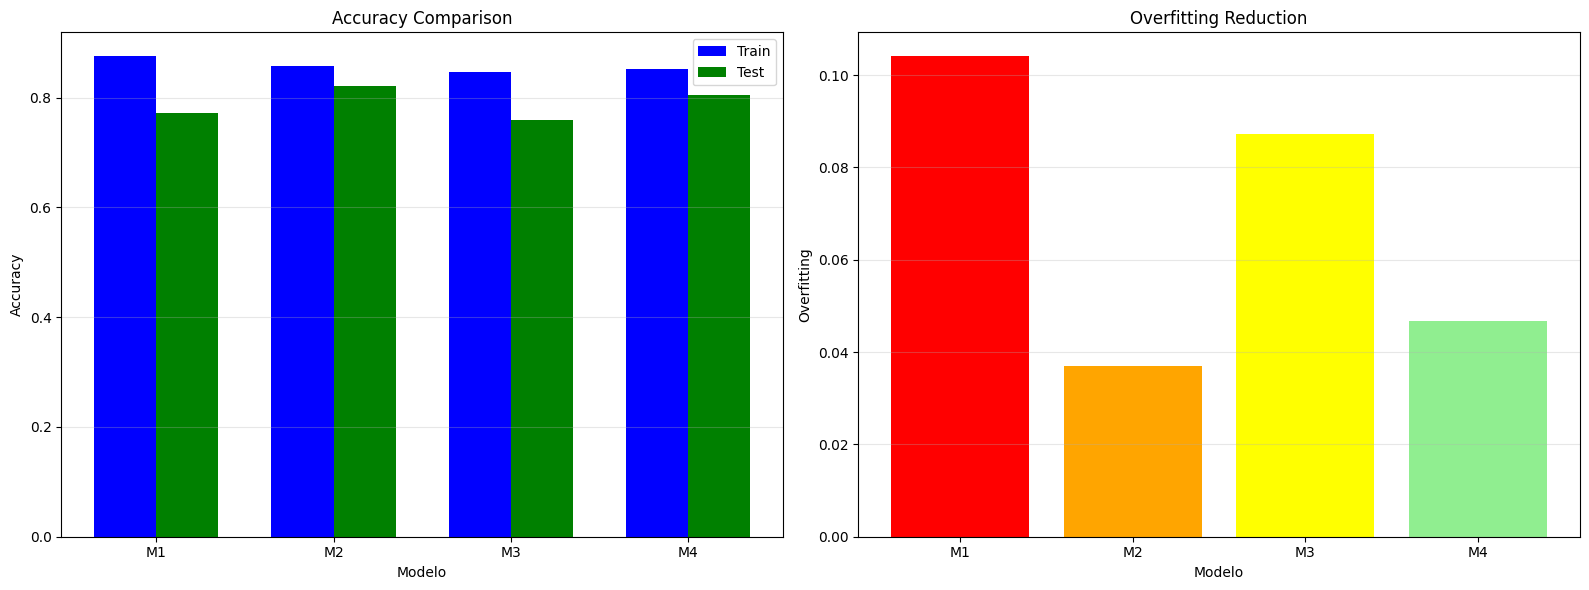

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x_pos = np.arange(len(df_resultados))
width = 0.35

axes[0].bar(x_pos - width/2, df_resultados['train_acc'], width, label='Train', color='blue')
axes[0].bar(x_pos + width/2, df_resultados['test_acc'], width, label='Test', color='green')
axes[0].set_xlabel('Modelo')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(['M1', 'M2', 'M3', 'M4'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(x_pos, df_resultados['overfitting'], color=['red', 'orange', 'yellow', 'lightgreen'])
axes[1].set_xlabel('Modelo')
axes[1].set_ylabel('Overfitting')
axes[1].set_title('Overfitting Reduction')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['M1', 'M2', 'M3', 'M4'])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Evaluación del Mejor Modelo

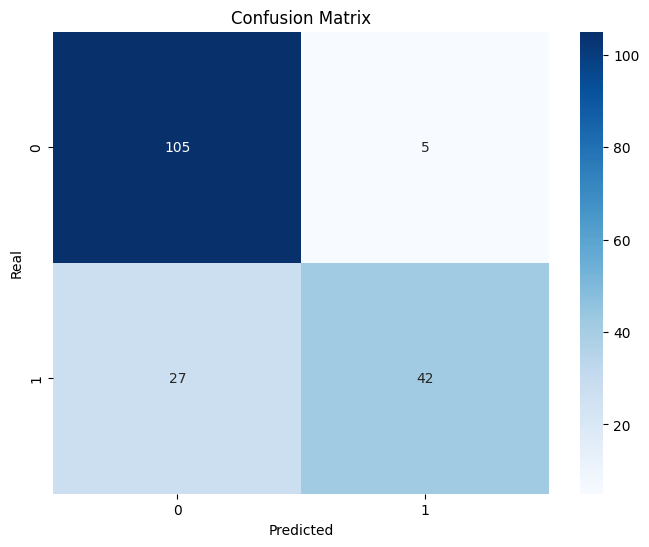


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       110
           1       0.89      0.61      0.72        69

    accuracy                           0.82       179
   macro avg       0.84      0.78      0.80       179
weighted avg       0.83      0.82      0.81       179



In [20]:
y_pred_proba = modelo_2.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Real')
plt.xlabel('Predicted')
plt.show()

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

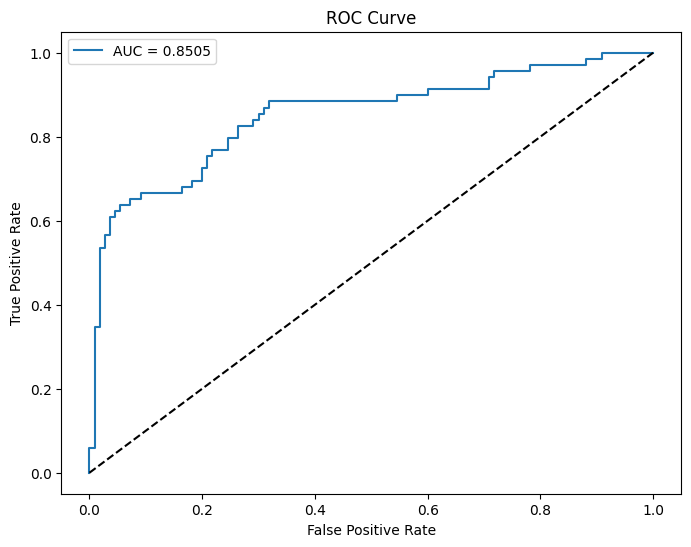

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Interpretra Curva de ROC
cómo leerla

Eje X: FPR (False Positive Rate) = FP / (FP + TN).

Eje Y: TPR (Recall/Sensitivity) = TP / (TP + FN).

Cada punto de la curva corresponde a un umbral distinto aplicado a las probabilidades del modelo.

La línea punteada (diagonal) es un clasificador aleatorio: TPR = FPR.

qué significa el AUC

AUC = área bajo la curva.

Va de 0.5 (azar) a 1.0 (perfecto).

Interpretación útil: es la probabilidad de que el modelo le asigne mayor score a un positivo que a un negativo al azar.

AUC ≈ 0.8505 → buena capacidad de discriminación.

forma de la curva

Más cerca de la esquina superior izquierda (TPR alto con FPR bajo) = mejor.

Si cae por debajo de la diagonal, el modelo está peor que el azar (podrías invertir la predicción).

elegir un umbral

Depende del coste de errores:

Si falsos negativos son muy caros (p. ej., detectar enfermos), elige un punto con TPR alto, tolerando más FPR.

Si falsos positivos son caros (p. ej., fraudes), muévete hacia FPR bajo aunque baje TPR.

## Conclusiones

Hemos visto cómo mejorar progresivamente un modelo MLP:

- **MODELO 1**: Baseline con overfitting
- **MODELO 2**: Dropout reduce overfitting
- **MODELO 3**: BatchNorm estabiliza entrenamiento
- **MODELO 4**: L2 controla pesos

Técnicas clave:
- Dropout para regularización
- Batch Normalization para estabilidad
- L2 para control de pesos
- Early Stopping para evitar sobreentrenamiento